In [1]:
from enum import Enum

class Operator(Enum):
    ADD = '+'
    MUL = '*'
    POW = '^'
    NEG = '-'
    LOG = 'ln'

    def __str__(self):
        return self.value

In [2]:
from graphviz import Digraph
from IPython.display import display

def visualize(tensor, graph='compute graph'):
    dot = Digraph(comment=graph)
    added_edges = set()

    def add_node(x):
        fillcolor = 'white' if x.requires_grad else 'lightcoral'
        if graph == 'compute graph':
            dot.node(str(id(x)), f"{x.data:.3f}", style='filled', fillcolor=fillcolor)
        else:
            dot.node(str(id(x)), f"{x.grad:.3f}", style='filled', fillcolor=fillcolor)
    # add_node = lambda x: 
    add_op_node = lambda x: dot.node(str(id(x)), str(x.type))

    def add_edge(start,end):
        x = str(id(start))
        y = str(id(end))
        edge = (x,y)
        if edge not in added_edges:
            dot.edges([edge])
            added_edges.add(edge)


    def make_graph(t: Tensor):
        add_node(t)
        if t.op:
            add_op_node(t.op)
            if graph == 'compute graph':
                add_edge(t.op, t)
            else: 
                add_edge(t, t.op)

            if t.op.left:
                make_graph(t.op.left)
                if graph == 'compute graph':
                    add_edge(t.op.left, t.op)
                else: 
                    add_edge(t.op, t.op.left)

            if t.op.right:
                make_graph(t.op.right)
                if graph =='compute graph':
                    add_edge(t.op.right, t.op)
                else:
                    add_edge(t.op, t.op.right)
    make_graph(tensor)
    display(dot)

In [3]:
from dataclasses import dataclass
class Op:
    def __init__(self, type: str, left, right=None):
        self.type = type
        self.left = left
        self.right = right

In [4]:
import math
@dataclass
class Tensor:
    data: float
    op: Op | None = None
    grad: float = 0.0
    requires_grad: bool = True

    @staticmethod
    def ensure_tensor(value, requires_grad=False):
        return value if isinstance(value, Tensor) else Tensor(value, requires_grad=requires_grad)

    def validate_arg(fn):
        def wrapper(self, other):
            other = Tensor.ensure_tensor(other, requires_grad=False)
            return fn(self, other)
        return wrapper

    @validate_arg
    def __add__(self, other):
        n = self.data + other.data
        op = Op(Operator.ADD, self, other)
        return Tensor(n, op)
    def __radd__(self, other):
        return self + other
    @validate_arg
    def __mul__(self, other):
        n = self.data * other.data
        op = Op(Operator.MUL, self, other)
        return Tensor(n, op)
    
    def __rmul__(self, other):
        return self * other
    
    @validate_arg
    def __pow__(self, power):
        try:
            n = self.data ** power.data
        except ZeroDivisionError:
            n = float('nan')
        op = Op(Operator.POW, self, power)
        return Tensor(n, op)
    
    @validate_arg
    def __rpow__(self, base):
        return base ** self
    
    @validate_arg
    def __sub__(self, other):
        return self + (-other)
    def __rsub__(self, other):
        return -self + other
    
    @validate_arg
    def __truediv__(self, other):
        return self * other ** -1 
    
    def __rtruediv__(self, other):
        return other * self ** -1

    def __neg__(self):
        data = -self.data
        op = Op(Operator.NEG, self)
        return Tensor(data, op)
    
    def log(self):
        data = math.log(self.data)
        op = Op(Operator.LOG, self)
        return Tensor(data, op)
    
    def __lt__(self, other):
        return self.data < other

    def backward(self):
        self.grad += 1.0
        self._backward()

    def _backward(self):
        op = self.op
        if not op:
            return
        match op.type:
            case Operator.ADD:
                op.left.grad += self.grad
                op.right.grad += self.grad

            case Operator.MUL:
                op.left.grad += self.grad * op.right.data 
                op.right.grad += self.grad * op.left.data

            case Operator.POW:
                n = op.right.data
                op.left.grad += self.grad * n * op.left.data ** (n-1)

                base = op.left.data
                op.right.grad += self.grad * self.data * math.log(base)
            case Operator.NEG:
                assert op.right is None, "Unary Operation can't have two operands"
                op.left.grad += -self.grad
            case Operator.LOG:
                assert op.right is None, "Unary Operation can't have two operands"
                op.left.grad += self.grad * (op.left.data ** -1)


        if op.left:
            op.left._backward()
        if op.right:
            op.right._backward()
    def item(self):
        return self.data
    

@dataclass
class Optimizer:
    params: list[Tensor]
    lr: float= 0.01

    def step(self):
        for param in self.params:
            if param.requires_grad:
                param.data = param.data - self.lr * param.grad

    def zero_grad(self):
        for t in self.params:
            t.grad = 0.0

In [5]:
class Module:
    def params(self):
        return self._collect_params(self.__dict__)

    def _collect_params(self, obj):
        params = []

        if isinstance(obj, Tensor):
            params.append(obj)

        elif isinstance(obj, Module):
            params.extend(obj.params())

        elif isinstance(obj, dict):
            for v in obj.values():
                params.extend(self._collect_params(v))

        elif isinstance(obj, (list, tuple)):
            for item in obj:
                params.extend(self._collect_params(item))

        return params
    def __call__(self, *args, **kwds):
        return self.forward(*args, **kwds)

In [6]:
def chunks(lst, n):
    for i in range(0, len(lst), n):
        yield lst[i:i+n]

from random import uniform
class Linear(Module):
    def __init__(self, in_features:int , out_features: int, bias=True):
        self.input = in_features
        self.output = out_features
        self.bias_flag = bias

        self.weights = [Tensor(self.init_weight()) for _ in range(self.input * self.output)]
        if bias:
            self.bias = [Tensor(self.init_weight()) for _ in range(self.output)]
        else: 
            self.bias = [0]*len(self.output) # on the assumption that raw int value converted to Tensor are always with requires grad= False
    def init_weight(self):
        return uniform(-0.5, 0.5)
    def forward(self, x: list):
        assert len(x[0]) == self.input, f"Got {len(x)} features, expected {self.input}"

        output = []
        dot_prod = lambda x, w, b: sum([xi * wi for xi, wi in zip(x,w)], b)

        # the loop un-batches the input -- gets single input point at a time
        for inp in x: 
            weight = chunks(self.weights, self.input) 
            out = [dot_prod(inp, w, b) for w, b in zip(weight, self.bias)]
            output.append(out)
        return output


In [7]:
sigmoid = lambda x: 1/(1+math.e**-x)

In [8]:
class BCELogitsLoss:
    def __init__(self):
        self.sigmoid = lambda x: [sigmoid(v) for v in x]
        self.threshold = 1e-6
    def __call__(self, logits, labels):
        eps = self.threshold
        logits = [x for sample in logits for x in sample]
        prob = self.sigmoid(logits)
        loss = [
            -(y * (eps + p).log() + (1-y)*(1-p + eps).log())
            for y, p in zip(labels, prob)
        ]
        
        return sum(loss)/len(loss)

In [9]:
class XOR(Module):
    def __init__(self):
        self.hidden_layer = Linear(2,2)
        self.output_layer = Linear(2,1)
        self.activation = lambda x: [[sigmoid(x) for x in sample] for sample in x]

    def forward(self, x):
        # x [B, (F)]
        x = self.hidden_layer(x)
        x = self.activation(x)
        x = self.output_layer(x)
        return x
        # return self.activation(x) #if prob = 0 then log(0) will go mad; handle this in loss function

In [29]:
def train(model, x, y, optimizer:Optimizer, loss, epoch):
    loss_history = []
    for i in range(epoch):
        optimizer.zero_grad()
        y_pred = model(x)
        output: Tensor= loss(y_pred, y)
        output.backward()
        optimizer.step()

        loss_history.append(output.item())

        if i % 100_000 == 0:
            print(f"Epoch {i}: Loss: {output.item()}")
    plot(loss_history, epoch) 
    return model

def plot(loss_history, epoch):
    import matplotlib.pyplot as plt
    plt.plot(range(epoch), loss_history)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Epoch vs Loss')
    plt.show()

In [30]:
x = [(0,0), (0,1), (1,0), (1,1)]
y = [0, 1, 1, 0]

In [31]:
model = XOR()
y_pred = model(x)
optimizer = Optimizer(model.params())
loss = BCELogitsLoss()
epoch = 500_000

In [32]:
model.params()

[Tensor(data=0.33850083559798305, op=None, grad=0.0, requires_grad=True),
 Tensor(data=-0.29440902809104197, op=None, grad=0.0, requires_grad=True),
 Tensor(data=0.07827190477553958, op=None, grad=0.0, requires_grad=True),
 Tensor(data=0.05260560442982143, op=None, grad=0.0, requires_grad=True),
 Tensor(data=0.46499423019244346, op=None, grad=0.0, requires_grad=True),
 Tensor(data=0.33603022979318475, op=None, grad=0.0, requires_grad=True),
 Tensor(data=0.16818742020291133, op=None, grad=0.0, requires_grad=True),
 Tensor(data=-0.2870020890295887, op=None, grad=0.0, requires_grad=True),
 Tensor(data=-0.384317441809209, op=None, grad=0.0, requires_grad=True)]

Epoch 0: Loss: 0.7186323303493934
Epoch 100000: Loss: 0.7513309932069105
Epoch 200000: Loss: 0.004963117778378322
Epoch 300000: Loss: 0.001981588953159913
Epoch 400000: Loss: 0.0012527566956060821


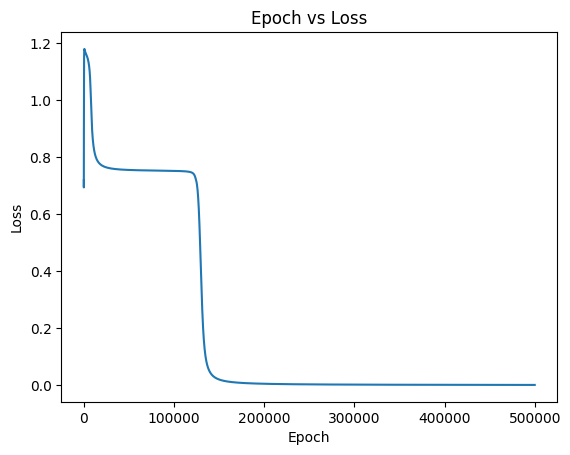

[Tensor(data=8.809573677999861, op=None, grad=-1.2971162806556634e-05, requires_grad=True),
 Tensor(data=8.753448585240347, op=None, grad=-1.3229229937774673e-05, requires_grad=True),
 Tensor(data=-6.450265338780484, op=None, grad=0.00012409212211663822, requires_grad=True),
 Tensor(data=-6.492907158562415, op=None, grad=0.0001243100222421481, requires_grad=True),
 Tensor(data=-1.8661178736247797, op=None, grad=0.00016211418990500794, requires_grad=True),
 Tensor(data=9.763681214883166, op=None, grad=-0.00019178387198741598, requires_grad=True),
 Tensor(data=20.048792609783405, op=None, grad=5.56098146390257e-05, requires_grad=True),
 Tensor(data=15.740124265184402, op=None, grad=-0.0005060672234386918, requires_grad=True),
 Tensor(data=-26.464747095143036, op=None, grad=0.0002047329987644067, requires_grad=True)]

In [33]:
model = train(model,x,y, optimizer, loss, epoch)
model.params()

In [27]:
y_pred = model(x)

In [28]:
preds = [[round(sigmoid(tensor.data)) for tensor in sample] for sample in y_pred]
print("Predictions:", preds)
print("Ground Truth:", y)

Predictions: [[0], [1], [1], [0]]
Ground Truth: [0, 1, 1, 0]


In [17]:
model.params()

[Tensor(data=8.65993702664116, op=None, grad=-4.2626091363353e-05, requires_grad=True),
 Tensor(data=8.620256031856979, op=None, grad=-4.256008720571029e-05, requires_grad=True),
 Tensor(data=6.906810377913463, op=None, grad=-4.460792853438899e-05, requires_grad=True),
 Tensor(data=6.952226158527299, op=None, grad=-4.472410513286865e-05, requires_grad=True),
 Tensor(data=-3.640780302086709, op=None, grad=2.3591747622183242e-05, requires_grad=True),
 Tensor(data=-10.843720939735897, op=None, grad=6.702076983949835e-05, requires_grad=True),
 Tensor(data=17.11490464226742, op=None, grad=-0.0001912448544707273, requires_grad=True),
 Tensor(data=-17.685646888663285, op=None, grad=0.0001911735964207764, requires_grad=True),
 Tensor(data=-7.346709828695451, op=None, grad=9.431573406046434e-05, requires_grad=True)]

In [18]:
xor = XOR()
xl = BCELogitsLoss()

In [19]:
y_p = xor(x)

In [20]:
out = xl(y_p, y)

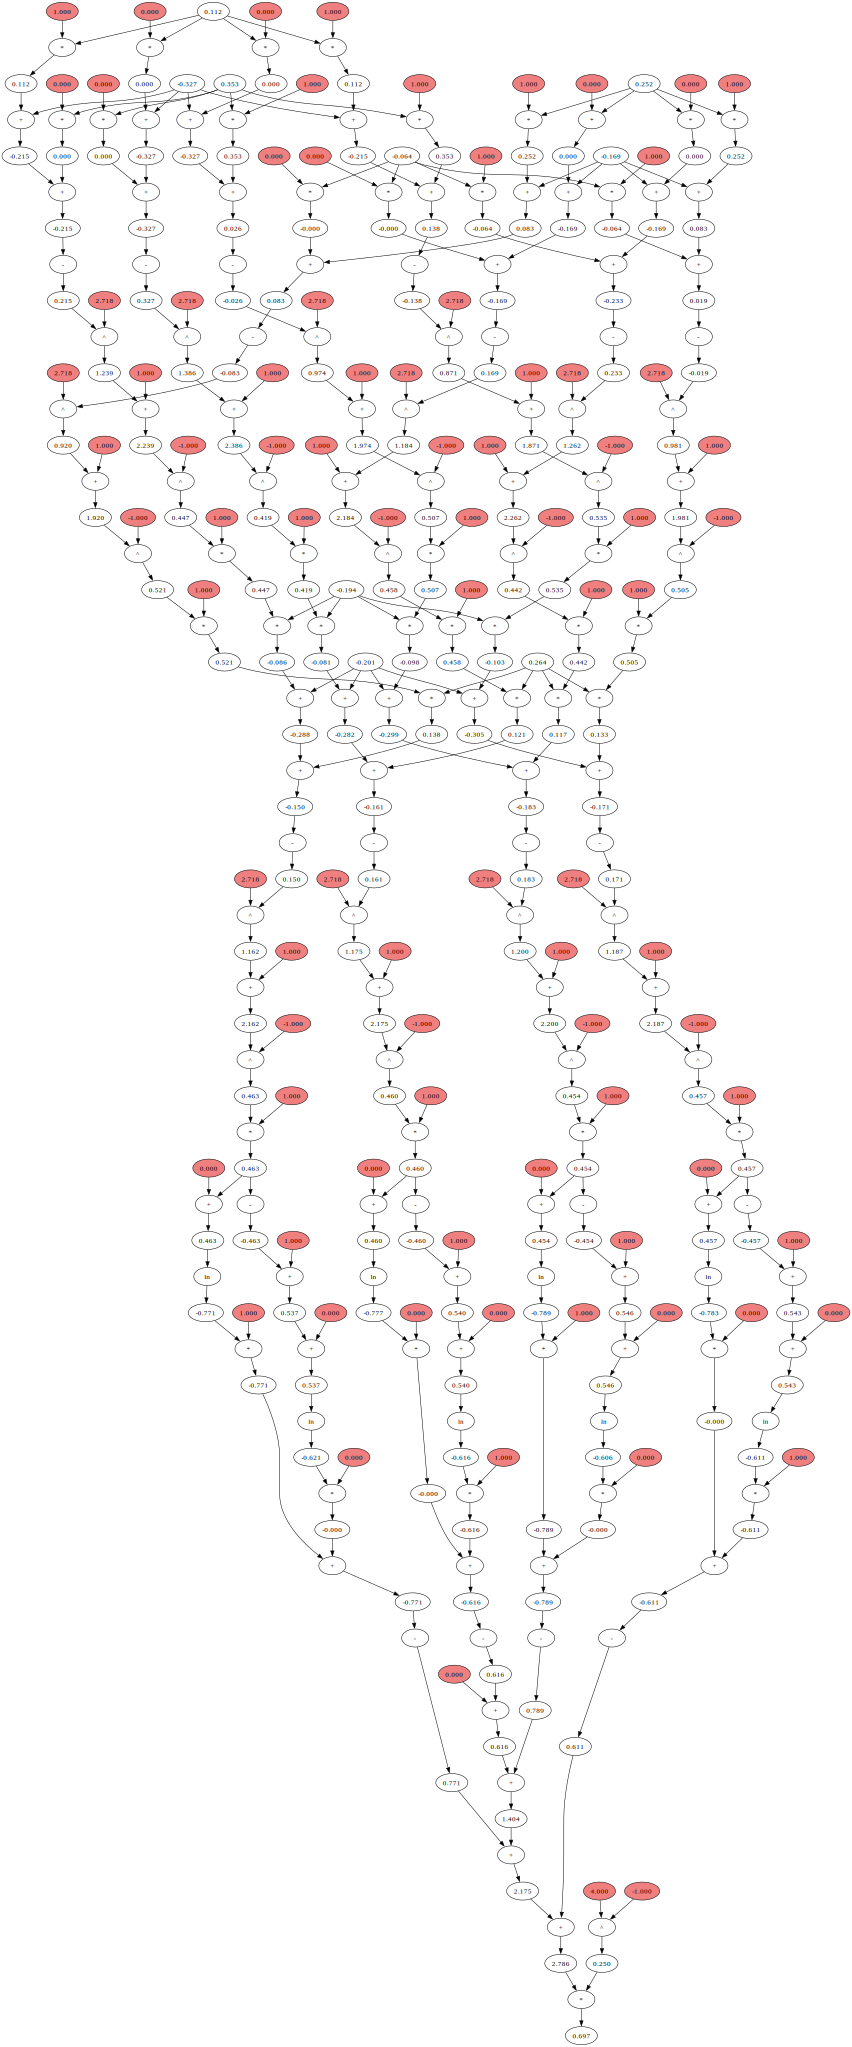

In [21]:
visualize(out)

In [22]:
a = Tensor(2)
b = Tensor(4)


In [23]:
c = a/b